In [188]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from graphviz import Digraph
%matplotlib inline

In [175]:
class Value:

    def __init__(self, data: float, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * out.grad # += instead of = 
            other.grad += 1.0 * out.grad # due to multivariable case of duplicate variables

        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other # we don't need a label to return this because __mul__ already does that
        # we just redirect it to the correct order
        # we pass in this since we know that self is for sure a value object
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad # assuming that other != 0
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other) # there is no need for a gradient function here because it builds automatically from + and *
    
    def __rsub__(self, other): # other - self
        return (-self) + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-(t**2)) * out.grad # note t = out.data

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) 
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = "record")

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


# backprop via a neuron

In [123]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

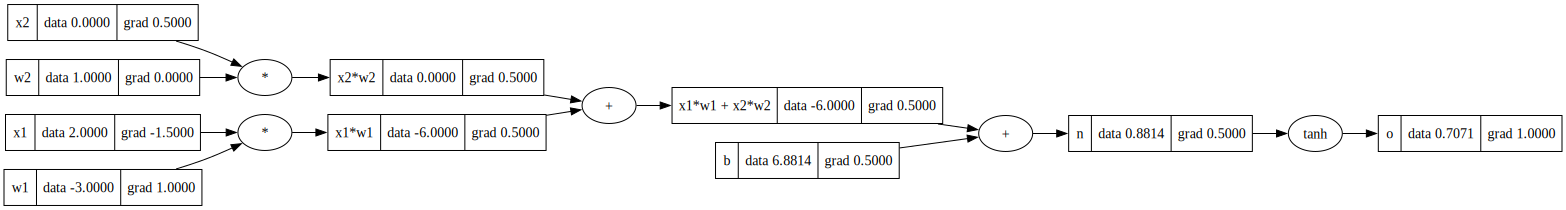

In [124]:
draw_dot(o)

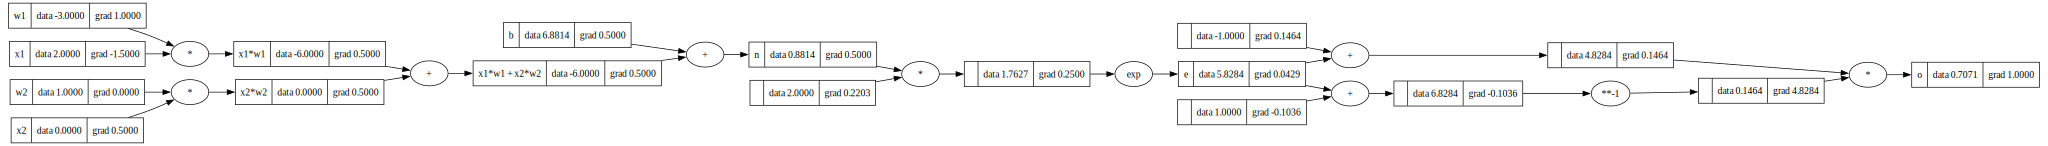

In [127]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [128]:
import torch

In [187]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# o

# a = torch.Tensor([2.0])
# a.data.item()
# torch can do what micrograd does in a special case
# where all the tensors are single element tensors
# but the big deal is everything is more efficient 
# as we work with these tensor objects where operations can be done in parallel
# neural nets are just a specific class of mathematical functions

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [369]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x): # x is the inputs from previous neurons
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # assumes we don't have a middle layer of 1 neuron so zip 
        # in line 9 would not work as Value object is not iterable

class MLP:

    def __init__(self, nin, nouts): # nouts is a list of all the layers excluding input layer, which is nin
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

a = Value(2.0); a.label = 'a'
b = Value(3.0); b.label = 'b'
c = Value(-1.0); c.label = 'c'
x = [a, b, c]
n = MLP(3, [4, 4, 1])
o = n(x)
print(o)
o.backward()

Value(data=0.3617203649953905)


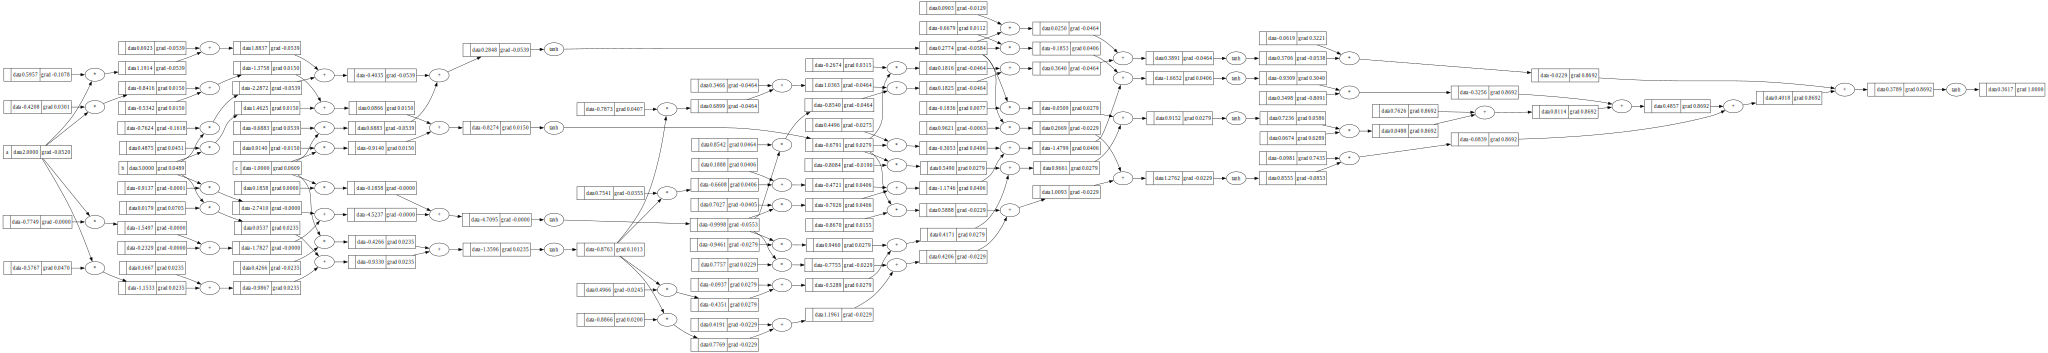

In [370]:
draw_dot(o) # figure out how this is possible !? isn't this for value objects with nodes and children? how does this work?
# this makes sense because this final operation is just the dot product multiplications + bias, from which the previous weights 
# are just the same thing until all the way to the original inputs, weights and biases. so technically, you calling a draw dot 
# here is the exact same as a mathematical function since this is a very big mathematical function at the end of the day

In [367]:
a = 12.0
b = 1.0
c = -4.0
print([id(a), id(b), id(c)])
eg = [a, b, c]
gen = zip([12, 2, 3], eg)
print(list(id(x2) for x1, x2 in gen)) # this shows that zip preserves the object and does not make a new one

[6133242416, 6133242576, 6133242224]
[6133242416, 6133242576, 6133242224]
